In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import win32com.client as win32
import sqlite3 as sql
from scipy.optimize import minimize
from scipy.optimize import fsolve
import time

In [2]:
aspen=win32.Dispatch('Apwn.Document')
direccion="C:\\Users\\ASUS\\Documents\\Universidad\\Tesis\\Convergencia_Newton\\Simulación\\equation_oriented.apw"

aspen.InitFromArchive2(direccion)
aspen.visible=False
print(f"Aspen cargado")
def correr_simulacion(aspen):
    aspen.Engine.Run2()
    while aspen.Engine.isRunning:
        time.sleep(1)



Aspen cargado


In [3]:
def error(x1,x2):
    return (x1-x2)/x1
def calculo_error(x,args):
    aspen=args
    # Se realiza un analisis solo para dos variables, el flujo y una concentración
    # Se considera que la concentración de etanol se aproxima a 0, por lo que habria solo dos componentes en la mezcla
    flujo,x1=x
    x2=1-x1
    if x1>=1:
        x1=1
        x2=0
    # bloques=aspen.Tree.Elements.Item('Data').Elements.Item('Blocks')
    corrientes=aspen.Tree.Elements.Item('Data').Elements.Item('Streams')
    corriente_ingreso=corrientes.Elements.Item('GLR+').Elements.Item("Input")
    Flujo_ingreso=corriente_ingreso.Elements.Item("TOTFLOW").Elements.Item("MIXED")
    Flujo_ingreso.Value=flujo
    concentracion_ingreso=corriente_ingreso.Elements.Item("FLOW").Elements.Item("MIXED")
        
    concentracion_ingreso.Elements.Item("GLYCE-01").Value=x1
    concentracion_ingreso.Elements.Item("WATER").Value=x2
    # concentracion_ingreso.Elements.Item("ETHAN-01").Value=x3
    
    correr_simulacion(aspen)
    
    corriente_salida=corrientes.Elements.Item('GLR').Elements.Item("Output")
    flujo_salida=corriente_salida.Elements.Item("TOT_FLOW").Value
    concentracion_salida=corriente_salida.Elements.Item("MOLEFRAC").Elements.Item("MIXED")
    salida_glicerina=concentracion_salida.Elements.Item("GLYCE-01").Value
    salida_agua=concentracion_salida.Elements.Item("WATER").Value
    salida_etanol=concentracion_salida.Elements.Item("ETHAN-01").Value
    error_glicerina=error(salida_glicerina,x1)
    # error_agua=error(salida_agua,1-x1)
    error_flujo=error(flujo_salida,flujo)
    # print(f"el flujo supuesto es {flujo} y el flujo real es {flujo_salida}")
    # error_etanol=error(salida_etanol,1-x1-x2)
    return [error_flujo,error_glicerina]
    # norma=np.linalg.norm([error_glicerina,error_agua,error_flujo,error_etanol])
    # return norma
    
    

In [10]:
def jacobiano(variables,ASPEN):
    # Estas son las variables que se van a modificar, en este caso el flujo y la concentración
    flujo,x1=variables
    delta=0.0001
    
    flujo_1=flujo+delta*flujo
    flujo_2=flujo-delta*flujo
    
    x1_1=x1+delta*x1
    x1_2=x1-delta*x1
    
    DS=ASPEN.Tree.Elements.Item("Data").Elements.Item("Flowsheeting Options").Elements.Item("Design-Spec")
    Limite_Flujo=DS.Elements.Item("DS-1").Elements.Item("Input").Elements.Item("EXPR2").Value
    Limite_Flujo=int(Limite_Flujo)
    if x1_1>=1:
        x1_1=1
        x1_2=1-2*delta
    if flujo_1>=Limite_Flujo:
        flujo_1=Limite_Flujo
        flujo_2=Limite_Flujo-2*delta
    delta_flujo=flujo_1-flujo_2
    delta_x1=x1_1-x1_2
    J=np.zeros((2,2))
    J[0,0]=(calculo_error([flujo_1,x1],ASPEN)[0]-calculo_error([flujo_2,x1],ASPEN)[0] )/delta_flujo
    J[0,1]=(calculo_error([flujo,x1_1],ASPEN)[0]-calculo_error([flujo,x1_2],ASPEN)[0] )/delta_x1
    J[1,0]=(calculo_error([flujo_1,x1],ASPEN)[1]-calculo_error([flujo_2,x1],ASPEN)[1] )/delta_flujo
    J[1,1]=(calculo_error([flujo,x1_1],ASPEN)[1]-calculo_error([flujo,x1_2],ASPEN)[1] )/delta_x1
    return J
    

In [5]:
def newton_raphson(fun,variables,ASPEN,iteraciones_maximas=10):
    tol=1e-6
    error=1
    iteracion=0
    memoria=np.zeros((0,2))
    memoria=np.append(memoria,[variables],axis=0)
    errores=np.zeros((0,2))
    DS=ASPEN.Tree.Elements.Item("Data").Elements.Item("Flowsheeting Options").Elements.Item("Design-Spec")
    Limite_Flujo=DS.Elements.Item("DS-1").Elements.Item("Input").Elements.Item("EXPR2").Value
    Limite_Flujo=int(Limite_Flujo)
    print(Limite_Flujo)
    while error>tol and iteracion<iteraciones_maximas:
        if variables[0]>=Limite_Flujo:
            variables[0]=Limite_Flujo
        J=jacobiano(variables,ASPEN)
        # print(J)
        F=np.array(fun(variables,ASPEN))
        # print(F)
        invJ=np.linalg.inv(-J)
        print("invJ")
        print(invJ)
        delta=invJ.dot(F)
        print("delta")
        print(delta)
        # delta=np.linalg.solve(J,-F)
        variables=variables+delta
        print(variables[0])
        error=np.linalg.norm(F)
        memoria=np.append(memoria,[variables],axis=0)
        print(iteracion)
        errores=np.append(errores,[F],axis=0)
        iteracion+=1
    return variables,memoria,iteracion,errores

In [6]:
x=[96,0.9997]
calculo_error(x,aspen)

[0.026893333348605657, 0.0002995231428724519]

In [7]:
jacobiano(x,aspen)

array([[-1.01365278e-02,  0.00000000e+00],
       [ 1.04135519e-09, -7.00663886e-01]])

In [11]:
result=newton_raphson(calculo_error,x,aspen)

100
invJ
[[3.68091609e+03 0.00000000e+00]
 [0.00000000e+00 1.00001952e+00]]
delta
[9.86435101e+01 2.99529991e-04]
194.64351006306623
0
invJ
[[-7.22640025e+03 -0.00000000e+00]
 [ 0.00000000e+00  1.00001953e+00]]
delta
[9.86530115e+01 1.00941753e-09]
198.65301151676317
1
invJ
[[-7.22640025e+03 -0.00000000e+00]
 [ 0.00000000e+00  1.00001953e+00]]
delta
[ 9.86530115e+01 -2.02064631e-14]
198.65301151676317
2
invJ
[[-7.22640025e+03 -0.00000000e+00]
 [ 0.00000000e+00  1.00001953e+00]]
delta
[98.65301152  0.        ]
198.65301151676317
3
invJ
[[-7.22640025e+03 -0.00000000e+00]
 [ 0.00000000e+00  1.00001953e+00]]
delta
[98.65301152  0.        ]
198.65301151676317
4


KeyboardInterrupt: 

In [14]:
# aspen.Close()
aspen.Quit()

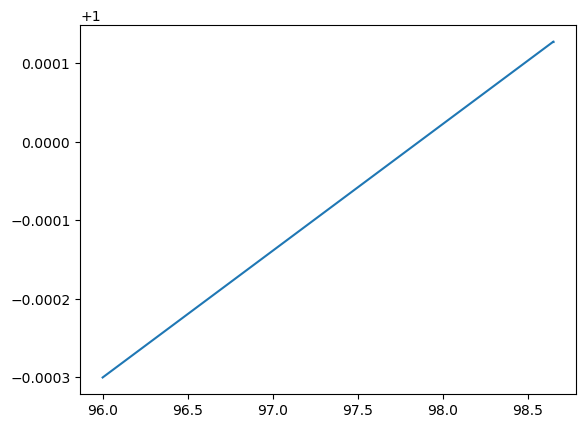

In [124]:
plt.figure()
plt.plot(result[1][:,0],result[1][:,1])
plt.show()

In [125]:
resultados=pd.DataFrame(result[1],columns=["Flujo","Concentración"])
resultados["Iteracion"]=np.arange(resultados.shape[0])
resultados.set_index("Iteracion",inplace=True)



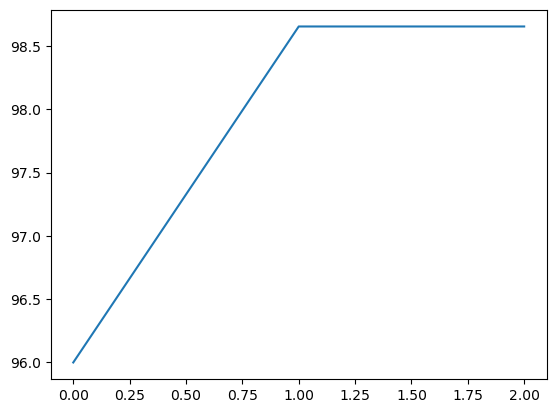

In [126]:
plt.figure()
plt.plot(resultados["Flujo"])
plt.show()

In [127]:
print(result)

(array([98.653111 ,  1.0001268]), array([[96.        ,  0.9997    ],
       [98.653111  ,  1.00012749],
       [98.653111  ,  1.0001268 ]]), 2, array([[ 2.68933333e-02,  2.99524143e-04],
       [ 0.00000000e+00, -4.70000221e-07]]))
